In [32]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils

from scipy import ndimage as ndi
from scipy.spatial.distance import euclidean
from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max

from preprocessing import *

In [21]:
o=get_origs()
get_clahes(o)
cell_masks = get_cell_masks()
cell_markers = get_cell_markers(cell_masks, 24)
weight_maps = get_weight_maps(cell_markers, False)

pimg(weight_maps[1])

KeyboardInterrupt: 

In [ ]:
def get_pred_masks():
    return get_binary_cell_masks(get_cell_masks())

def get_pred_markers(pred_masks, e_r):
    return get_binary_cell_markers(get_cell_masks(), e_r)

In [280]:
def threshold_binary_image(img, thresh=0.5):
    image = img.copy()
    return (image*1.0 >= thresh).astype('uint8')

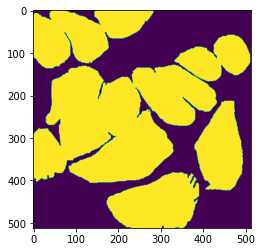

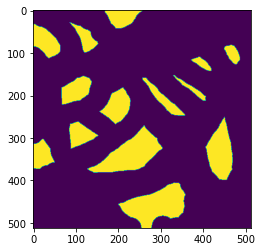

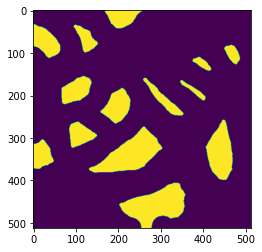

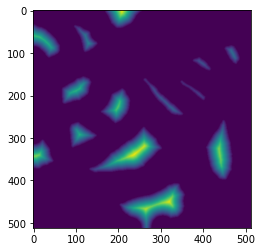

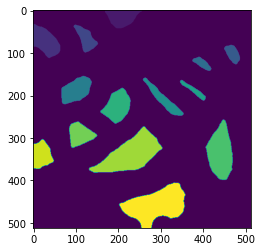

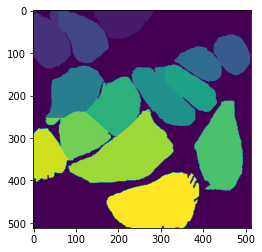

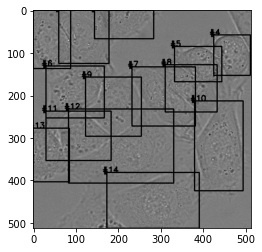

In [281]:
ELEMENT_NO = 1
# 0 -> Fluo, 1-> DIC, 2 -> PhC

pred_masks = get_pred_masks()
pred_markers = get_pred_markers(pred_masks, 24)
# erosion_radius = 8 for 0, 24 for 1, 2 for 2

#constants
OPEN_RADIUS = 4
# = 0 for 0, = 12 for 1, = 0 for 2

mask_thresh = threshold_binary_image(pred_masks[ELEMENT_NO], 0.5)

marker_thresh_unopen = threshold_binary_image(pred_markers[ELEMENT_NO], 0.5)
marker_thresh = cv2.morphologyEx(marker_thresh_unopen, cv2.MORPH_OPEN, disk(OPEN_RADIUS))


distance = ndi.distance_transform_edt(marker_thresh)

markers, _ = ndi.label(marker_thresh)

ws_labels = watershed(-distance, markers, mask=mask_thresh)

orig = get_origs()[ELEMENT_NO]

image = orig.copy()

#TODO: cite/recode following
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(ws_labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(image.shape, dtype="uint8")
    mask[ws_labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # draw a rectangle enclosing the object
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# plt.imshow(orig, cmap='gray')
# plt.show()

a = mask_thresh
b = marker_thresh_unopen
c = marker_thresh
d = distance
e = markers
f = ws_labels

pimg(a)
pimg(b)
pimg(c)
pimg(d)
pimg(e)
pimg(f)
    
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
def create_preprocessed_cache(dataset, new_dir_name=None):
    
    if new_dir_name == None:
        new_dir_name = dataset+"_cache"
    
    try:
        os.mkdir(new_dir_name)
        os.mkdir(os.path.join(new_dir_name, "originals"))
        os.mkdir(os.path.join(new_dir_name, "clahes"))
        os.mkdir(os.path.join(new_dir_name, "masks"))
        os.mkdir(os.path.join(new_dir_name, "markers"))
        os.mkdir(os.path.join(new_dir_name, "weight_maps"))
    except:
        print("One of the directories to be created already exists. Clear and try again.")
        return
    
    data = []
    paths = [dataset + '/01', dataset + '/02']
    count = 0
    
    for path in paths:
        mask_path = path + '_ST'
        mask_path = os.path.join(mask_path, "SEG")
        for f in os.listdir(mask_path):
            if not f.endswith(".tif"):
                continue
            image = cv2.imread(os.path.join(path, f.replace('man_seg', 't')), cv2.IMREAD_GRAYSCALE)
            clahe = equalize_clahe(image).astype(np.float32)
            mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
            print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('man_seg', 't')))
            
            # Generate the Cell Mask and Markers from the Mask
            cell_mask = (mask > 0).astype(np.uint8)
            markers = (get_markers(mask) > 0).astype(np.uint8)
            weight_map = get_weight_map(markers)
            
            index = 't' + str(count) + ".tif"
            count += 1
            
#             np.save(os.path.join(new_dir_name, "originals", index ), image)
#             np.save(os.path.join(new_dir_name, "clahes", index ), clahe)
#             np.save(os.path.join(new_dir_name, "masks", index ), cell_mask)
#             np.save(os.path.join(new_dir_name, "markers", index ), markers)
#             np.save(os.path.join(new_dir_name, "weight_maps", index ), weight_map)
            
            cv2.imwrite(os.path.join(new_dir_name, "originals", index ), image)
            cv2.imwrite(os.path.join(new_dir_name, "clahes", index ), clahe)
            cv2.imwrite(os.path.join(new_dir_name, "masks", index ), cell_mask)
            cv2.imwrite(os.path.join(new_dir_name, "markers", index ), markers)
            cv2.imwrite(os.path.join(new_dir_name, "weight_maps", index ), weight_map)

create_preprocessed_cache('DIC-2', new_dir_name=None)

   Loaded DIC-2/01_ST/SEG/man_seg000.tif, DIC-2/01/t000.tif
   Loaded DIC-2/01_ST/SEG/man_seg001.tif, DIC-2/01/t001.tif
   Loaded DIC-2/01_ST/SEG/man_seg002.tif, DIC-2/01/t002.tif
   Loaded DIC-2/01_ST/SEG/man_seg003.tif, DIC-2/01/t003.tif
   Loaded DIC-2/01_ST/SEG/man_seg004.tif, DIC-2/01/t004.tif
   Loaded DIC-2/01_ST/SEG/man_seg005.tif, DIC-2/01/t005.tif
   Loaded DIC-2/01_ST/SEG/man_seg006.tif, DIC-2/01/t006.tif
   Loaded DIC-2/01_ST/SEG/man_seg007.tif, DIC-2/01/t007.tif
   Loaded DIC-2/01_ST/SEG/man_seg008.tif, DIC-2/01/t008.tif
   Loaded DIC-2/01_ST/SEG/man_seg009.tif, DIC-2/01/t009.tif
   Loaded DIC-2/01_ST/SEG/man_seg010.tif, DIC-2/01/t010.tif
   Loaded DIC-2/01_ST/SEG/man_seg011.tif, DIC-2/01/t011.tif
   Loaded DIC-2/01_ST/SEG/man_seg012.tif, DIC-2/01/t012.tif
   Loaded DIC-2/01_ST/SEG/man_seg013.tif, DIC-2/01/t013.tif
   Loaded DIC-2/01_ST/SEG/man_seg014.tif, DIC-2/01/t014.tif
   Loaded DIC-2/01_ST/SEG/man_seg015.tif, DIC-2/01/t015.tif
   Loaded DIC-2/01_ST/SEG/man_seg016.tif

In [178]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 24)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[1]
# b = get_clahes(origs)[1]
# c = cell_masks[1]
# d = cell_markers[1]

# h = weight_maps[1]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)

In [179]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 8)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[0]
# b = get_clahes(origs)[0]
# c = cell_masks[0]
# d = cell_markers[0]

# h = weight_maps[0]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)

In [180]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 2)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[2]
# b = get_clahes(origs)[2]
# c = cell_masks[2]
# d = cell_markers[2]

# h = weight_maps[2]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)